In [41]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import MinMaxScaler

np.random.seed(29)


In [42]:
# Scales each feature to lie in [0, 1] and separate the data into training and
# test sets.

def preprocess_data(X, y):
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    return X_train, X_test, y_train, y_test
    

In [43]:

data = pd.read_csv('breast+cancer+wisconsin+diagnostic/wdbc.data', header=None).to_numpy()
X = data[:, 2:31]
y = data[:, 1]
X_train_wdbc, X_test_wdbc, y_train_wdbc, y_test_wdbc = preprocess_data(X, y)


data = pd.read_csv('arrhythmia/arrhythmia.data', header=None).replace('?', np.nan).to_numpy()
# Fills in missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data = imputer.fit_transform(data)
X = data[:, 0:278]
y = data[:, 279]
X_train_arrh, X_test_arrh, y_train_arrh, y_test_arrh = preprocess_data(X, y)


In [44]:
# Trains bagging model on top of logistic regression.
def bagging_log_regr(X_train, X_test, y_train, y_test, num_models, frac_samples):
    new_log_regr = LogisticRegression(penalty=None, max_iter=1000)
    bagging_classifier = BaggingClassifier(estimator=new_log_regr, 
                                           n_estimators=num_models, 
                                           max_samples=frac_samples)
    bagging_classifier.fit(X_train, y_train)
    return bagging_classifier.score(X_train, y_train), bagging_classifier.score(X_test, y_test)

# Plots training and testing accuracy vs. number of base learners.
def plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc):
    plt.plot(list_n_models, list_tr_acc, label='Train')
    plt.plot(list_n_models, list_te_acc, label='Test')
    nobag_tr = np.full(len(list_n_models), nobag_tr_acc)
    nobag_te = np.full(len(list_n_models), nobag_te_acc)
    plt.plot(list_n_models, nobag_tr, label='Train without bagging')
    plt.plot(list_n_models, nobag_te, label='Test without bagging')
    plt.legend(loc='best')
    plt.show()
    

1.0
0.9651162790697675
[0.9730848861283644, 0.9813664596273292, 0.9917184265010351, 0.9937888198757764, 0.9917184265010351, 0.9917184265010351, 0.9937888198757764]
[0.9767441860465116, 0.9651162790697675, 0.9767441860465116, 0.9767441860465116, 0.9651162790697675, 0.9767441860465116, 0.9651162790697675]


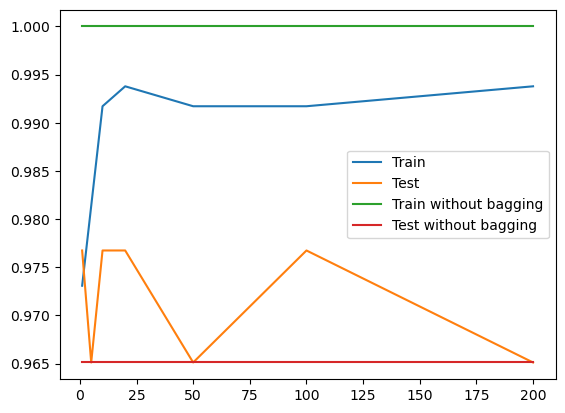

In [45]:
list_n_models = [1, 5, 10, 20, 50, 100, 200]

log_regr = LogisticRegression(penalty=None, max_iter=1000)
log_regr.fit(X_train_wdbc, y_train_wdbc)
nobag_tr_acc = log_regr.score(X_train_wdbc, y_train_wdbc)
nobag_te_acc = log_regr.score(X_test_wdbc, y_test_wdbc)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_models in list_n_models:
    tr_acc, te_acc = bagging_log_regr(X_train_wdbc,
                                      X_test_wdbc, y_train_wdbc, y_test_wdbc, n_models, 0.5)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

1.0
0.6029411764705882
[0.7786458333333334, 0.8802083333333334, 0.875, 0.890625, 0.8828125, 0.8828125, 0.8854166666666666]
[0.5441176470588235, 0.6029411764705882, 0.6323529411764706, 0.6323529411764706, 0.6323529411764706, 0.6617647058823529, 0.6323529411764706]


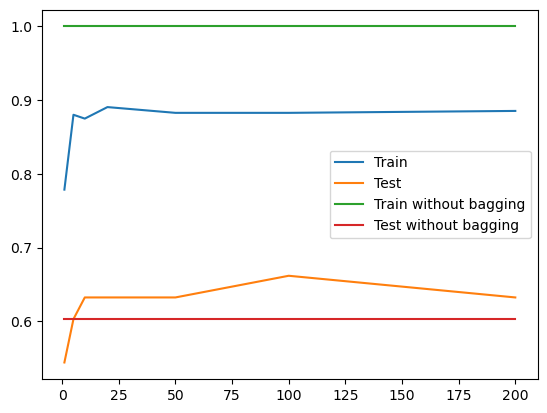

In [46]:
log_regr = LogisticRegression(penalty=None, max_iter=1000)
log_regr.fit(X_train_arrh, y_train_arrh)
nobag_tr_acc = log_regr.score(X_train_arrh, y_train_arrh)
nobag_te_acc = log_regr.score(X_test_arrh, y_test_arrh)
print(nobag_tr_acc)
print(nobag_te_acc)

list_tr_acc = []
list_te_acc = []
for n_models in list_n_models:
    tr_acc, te_acc = bagging_log_regr(X_train_arrh,
                                      X_test_arrh, y_train_arrh, y_test_arrh, n_models, 0.5)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_models(list_n_models, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)


In [47]:
# Plots training and test accuracies vs number of examples used to train each base learners.
def plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc):
    plt.plot(list_n_examples, list_tr_acc, label='Train')
    plt.plot(list_n_examples, list_te_acc, label='Test')
    nobag_tr = np.full(len(list_n_examples), nobag_tr_acc)
    nobag_te = np.full(len(list_n_examples), nobag_te_acc)
    plt.plot(list_n_examples, nobag_tr, label='Train without bagging')
    plt.plot(list_n_examples, nobag_te, label='Test without bagging')
    plt.legend(loc='best')
    plt.show()

1.0
0.9651162790697675
[0.9730848861283644, 0.9855072463768116, 0.989648033126294, 0.9917184265010351, 0.9937888198757764]
[0.9534883720930233, 0.9651162790697675, 0.9767441860465116, 0.9651162790697675, 0.9767441860465116]


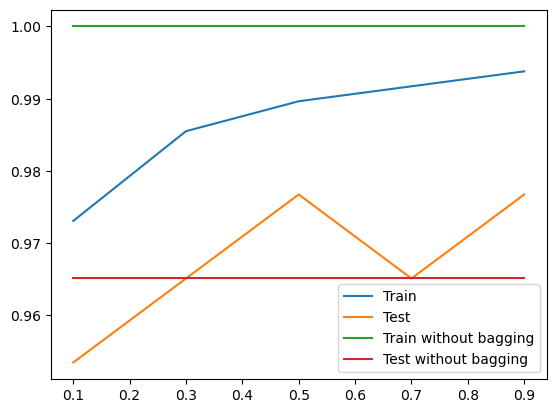

In [48]:
list_n_examples = [0.1, 0.3, 0.5, 0.7, 0.9]

log_regr = LogisticRegression(penalty=None, max_iter=1000)
log_regr.fit(X_train_wdbc, y_train_wdbc)
nobag_tr_acc = log_regr.score(X_train_wdbc, y_train_wdbc)
nobag_te_acc = log_regr.score(X_test_wdbc, y_test_wdbc)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_models in list_n_examples:
    tr_acc, te_acc = bagging_log_regr(X_train_wdbc,
                                      X_test_wdbc, y_train_wdbc, y_test_wdbc, 10, n_models)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)

1.0
0.6029411764705882
[0.6848958333333334, 0.796875, 0.8697916666666666, 0.9401041666666666, 0.9557291666666666]
[0.5441176470588235, 0.6176470588235294, 0.6176470588235294, 0.6323529411764706, 0.6323529411764706]


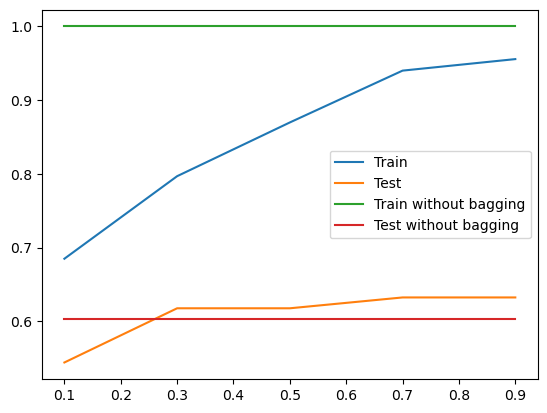

In [49]:
list_n_examples = [0.1, 0.3, 0.5, 0.7, 0.9]

log_regr = LogisticRegression(penalty=None, max_iter=1000)
log_regr.fit(X_train_arrh, y_train_arrh)
nobag_tr_acc = log_regr.score(X_train_arrh, y_train_arrh)
nobag_te_acc = log_regr.score(X_test_arrh, y_test_arrh)
print(nobag_tr_acc)
print(nobag_te_acc)


list_tr_acc = []
list_te_acc = []
for n_models in list_n_examples:
    tr_acc, te_acc = bagging_log_regr(X_train_arrh,
                                      X_test_arrh, y_train_arrh, y_test_arrh, 10, n_models)
    list_tr_acc.append(tr_acc)
    list_te_acc.append(te_acc)
print(list_tr_acc)
print(list_te_acc)
plot_acc_vs_n_examples(list_n_examples, list_tr_acc, list_te_acc, nobag_tr_acc, nobag_te_acc)